In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import print_function

import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')
from sklearn.model_selection import train_test_split

# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
tf.executing_eagerly()
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('INFO')

In [0]:
train_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
test_data  = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

In [4]:
train_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [5]:
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,-119.6,35.6,28.8,2599.6,530.0,1402.8,489.9,3.8,205846.3
std,2.0,2.1,12.6,2155.6,415.7,1030.5,365.4,1.9,113119.7
min,-124.2,32.6,1.0,6.0,2.0,5.0,2.0,0.5,22500.0
25%,-121.8,33.9,18.0,1401.0,291.0,780.0,273.0,2.5,121200.0
50%,-118.5,34.3,29.0,2106.0,437.0,1155.0,409.5,3.5,177650.0
75%,-118.0,37.7,37.0,3129.0,636.0,1742.8,597.2,4.7,263975.0
max,-114.5,41.9,52.0,30450.0,5419.0,11935.0,4930.0,15.0,500001.0


In [0]:
def pre_process_train_data(dataframe):
  features = dataframe.iloc[:,:-1]
  processed_features = features.copy()
  processed_features["rooms_per_person"] =  processed_features["total_rooms"] / processed_features["population"] 
  
  labels = pd.DataFrame()
  labels["median_house_value"] = dataframe.iloc[:,-1] / 1000.0
  return train_test_split(processed_features, labels, test_size = 0.2,shuffle=True)

def pre_process_test_data(dataframe):
  features = dataframe.iloc[:,:-1]
  processed_features = features.copy()
  processed_features["rooms_per_person"] =  processed_features["total_rooms"] / processed_features["population"] 
  
  labels = pd.DataFrame()
  labels["median_house_value"] = dataframe.iloc[:,-1] / 1000.0
  return processed_features, labels

In [0]:
X_train, X_val, y_train, y_val = pre_process_train_data(train_data)
X_test, y_test = pre_process_test_data(test_data)

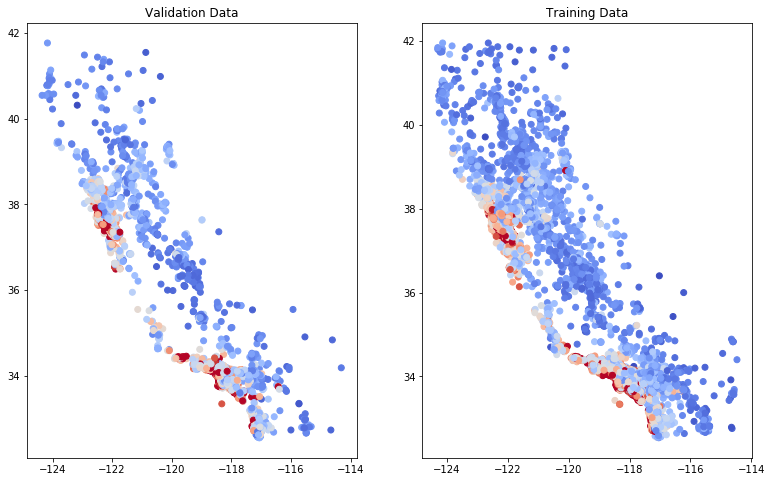

In [8]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")
plt.scatter(X_val["longitude"], X_val["latitude"],
            cmap="coolwarm",
            c=y_val["median_house_value"] / y_val["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")
plt.scatter(X_train["longitude"],
            X_train["latitude"],
            cmap="coolwarm",
            c=y_train["median_house_value"] / y_train["median_house_value"].max())
_ = plt.plot()

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True,count=None):
  ds = tf.data.Dataset.from_tensor_slices((dict(features),targets))
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
  ds = ds.batch(batch_size).repeat(count)
  return ds

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """
  feature_columns=construct_feature_columns(training_examples)
  
  my_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm =5.0)
  linear_regressor = tf.estimator.LinearRegressor(feature_columns = feature_columns,
                                       optimizer = my_optimizer) 
  
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn( training_examples, training_targets["median_house_value"], count=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], count=1, shuffle=False)

  print("Training model...")
  print("RMSE (on training data):")
  
  history = linear_regressor.train(input_fn=training_input_fn, steps=steps)
  
  training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
  training_predictions = np.array([item['predictions'][0] for item in training_predictions])
  
  validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
  validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
  
  # Compute training and validation loss.
  training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
  
  print("Model training finished.")
  print("Final RMSE (on training data): %0.3f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)
  # Output a graph of loss metrics over periods.
  # plt.ylabel("RMSE")
  # plt.xlabel("Periods")
  # plt.title("Root Mean Squared Error vs. Periods")
  # plt.tight_layout()
  # plt.plot(training_rmse, label="training")
  # plt.plot(validation_rmse, label="validation")
  # plt.legend()

  return linear_regressor

In [12]:
linear_regressor = train_model( learning_rate=0.00003,
                                steps=500,
                                batch_size=5,
                                training_examples=X_train,
                                training_targets=y_train,
                                validation_examples=X_val,
                                validation_targets=y_val )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpko2lreoy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f95d7c5e5c0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Instructions 

In [13]:
predict_test_input_fn = lambda: my_input_fn(X_test, y_test["median_house_value"], count=1, shuffle=False)

y_hat_test = linear_regressor.predict(input_fn=predict_test_input_fn)
y_hat_test = np.array([item['predictions'][0] for item in y_hat_test])

root_mean_squared_error = math.sqrt( metrics.mean_squared_error(y_hat_test, y_test))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpko2lreoy/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 162.02
